In [9]:
import pandas as pd

# Replace with your dataset path
file_path = "2022-06-28-2025-05-01-Russia-Ukraine.csv"

df = pd.read_csv(file_path, parse_dates=['event_date'])

# Quick look at unique event types
print(df['event_type'].unique())


['Explosions/Remote violence' 'Battles' 'Strategic developments'
 'Protests' 'Violence against civilians' 'Riots']


In [10]:
import numpy as np
from scipy.stats import zscore

# Select event types you're interested in
event_types = [
    'Protests', 'Riots', 'Violence against civilians',
    'Battles', 'Explosions/Remote violence'
]

# Filter and create daily count per event_type
event_ts = df[df['event_type'].isin(event_types)].groupby(
    [pd.Grouper(key='event_date', freq='D'), 'event_type']
).size().unstack().fillna(0)

# Smooth with 7-day rolling average
event_ts = event_ts.rolling(window=7, center=True).mean().dropna()

# Normalize each series with z-score
event_ts = event_ts.apply(zscore)

# Reset index for use with pyEDM
event_ts.reset_index(inplace=True)


In [13]:
import pyEDM

ccm_results = {}
E = 4 # embedding dimension
libSizes = "10 100 5"  # from 0 to 100 with step of 5

for cause in event_types:
    for effect in event_types:
        if cause == effect:
            continue

        # Extract cause-effect time series
        df_pair = event_ts[['event_date', cause, effect]].dropna()
        df_pair.columns = ['time', 'cause', 'effect']

        # Run CCM
        ccm_df = pyEDM.CCM(
            dataFrame=df_pair,
            E=E,
            columns="cause",
            target="effect",
            libSizes=libSizes,
            sample=100
        )

        # Convert to DataFrame and standardize column names
        df_ccm = pd.DataFrame(ccm_df)
        df_ccm.columns = [col.lower() for col in df_ccm.columns]

        # Dynamically identify rho column (e.g., 'protests:riots')
        rho_column = [col for col in df_ccm.columns if col != 'libsize'][0]

        # Store final rho (skill)
        final_rho = df_ccm.iloc[-1][rho_column]

        ccm_results[(cause, effect)] = final_rho

        


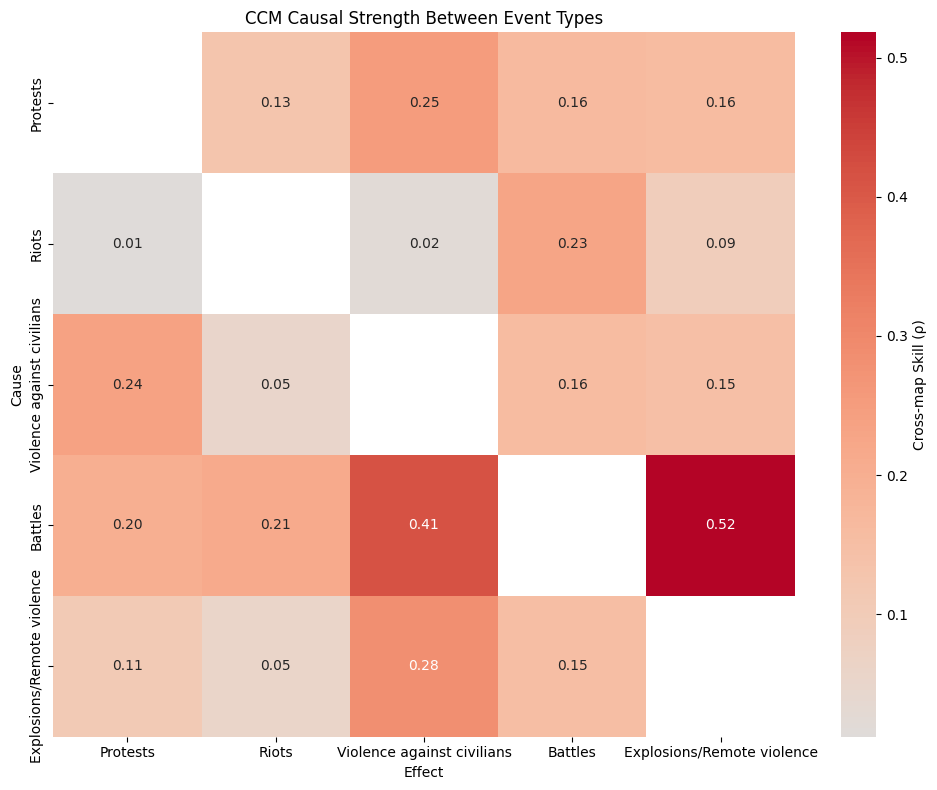

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create matrix for heatmap
causal_matrix = pd.DataFrame(index=event_types, columns=event_types)

for (cause, effect), rho in ccm_results.items():
    causal_matrix.loc[cause, effect] = rho

causal_matrix = causal_matrix.astype(float)

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(causal_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0,
            cbar_kws={"label": "Cross-map Skill (ρ)"})
plt.title("CCM Causal Strength Between Event Types")
plt.xlabel("Effect")
plt.ylabel("Cause")
plt.tight_layout()
plt.show()


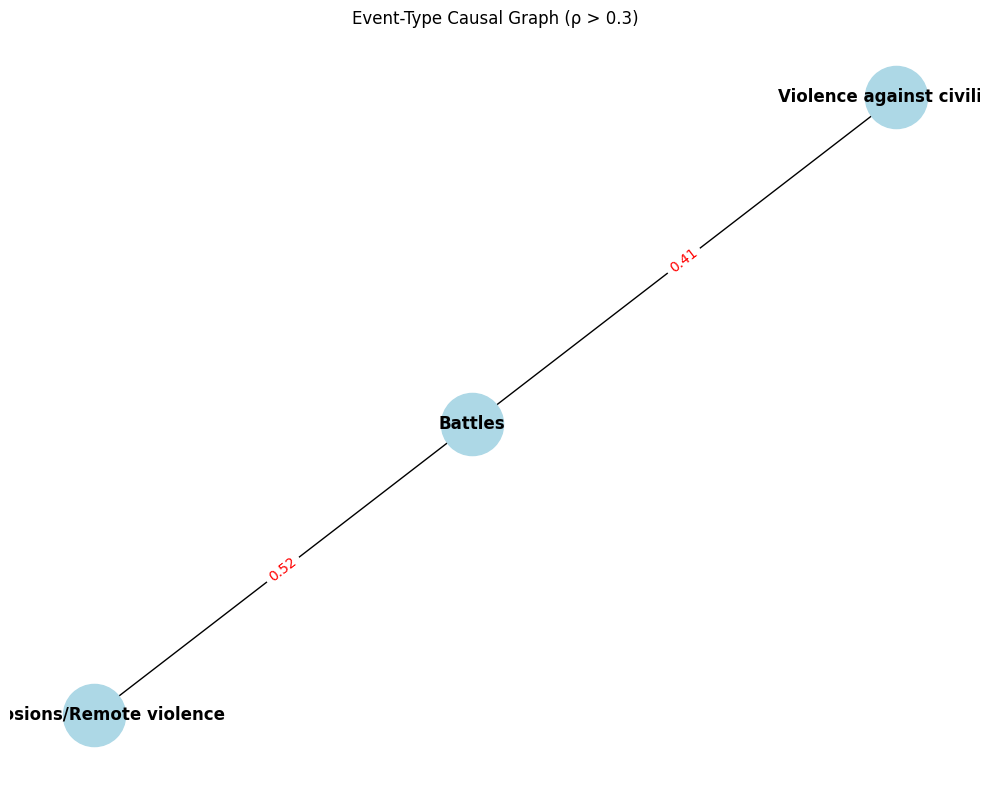

In [15]:
import networkx as nx

# Create directed graph
G = nx.DiGraph()

# Threshold for showing edges
threshold = 0.3

for (cause, effect), rho in ccm_results.items():
    if rho > threshold:
        G.add_edge(cause, effect, weight=round(rho, 2))

# Plot
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, k=0.6, seed=42)

nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='lightblue')
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=20)
nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'weight'), font_color='red')

plt.title("Event-Type Causal Graph (ρ > 0.3)")
plt.axis('off')
plt.tight_layout()
plt.show()
